In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2025-10-14 11:38:37.668966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760441917.988270      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760441918.062555      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.8.0


In [3]:
# Load MNIST dataset from Kaggle input directory (IDX format)
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

print("Loading MNIST dataset from Kaggle directory...")

# Load train and test data
X_train = read_idx('/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte')
y_train = read_idx('/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
X_test = read_idx('/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
y_test = read_idx('/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Unique labels: {np.unique(y_train)}")

Loading MNIST dataset from Kaggle directory...
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# Data preprocessing
print("\nPreprocessing data...")

# Reshape and normalize
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)

# Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_cat, test_size=0.15, random_state=42, stratify=y_train
)

print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_val shape: {y_val.shape}")
print("Data preprocessing completed!")


Preprocessing data...
X_train_split shape: (51000, 28, 28, 1)
X_val shape: (9000, 28, 28, 1)
y_train_split shape: (51000, 10)
y_val shape: (9000, 10)
Data preprocessing completed!


In [5]:
# Define custom Adaptive Attention Layer for FAAD-Net
class AdaptiveAttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AdaptiveAttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # Create trainable weight variables for attention
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AdaptiveAttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # Compute attention scores
        attention_scores = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        # Apply attention weights
        attended_features = x * attention_weights
        return attended_features
    
    def get_config(self):
        base_config = super(AdaptiveAttentionLayer, self).get_config()
        return base_config

print("Custom Adaptive Attention Layer defined successfully!")

Custom Adaptive Attention Layer defined successfully!


In [6]:
# Build FAAD-Net model with Adaptive Attention
print("\nBuilding FAAD-Net model...")

model = models.Sequential([
    # Input layer
    layers.Input(shape=(28, 28, 1)),
    
    # First Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second Conv Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third Conv Block with Attention
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Flatten before attention
    layers.Flatten(),
    
    # Apply Adaptive Attention Layer
    AdaptiveAttentionLayer(),
    
    # Dense layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(10, activation='softmax')
])

print("\nModel architecture:")
model.summary()


Building FAAD-Net model...


2025-10-14 11:38:59.274990: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_attention_layer        │ (None, 6272)           │    39,344,256 │
│ (AdaptiveAttentionLayer)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 41,125,994 (156.88 MB)

 Trainable params: 41,124,586 (156.88 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [7]:
# Compile the model
print("\nCompiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Total trainable parameters: {model.count_params():,}")


Compiling model...
Model compiled successfully!
Total trainable parameters: 41,125,994


In [8]:
# Train the model
print("\nTraining FAAD-Net model...")
print("This may take several minutes...\n")

# Define callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    batch_size=128,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nTraining completed!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


Training FAAD-Net model...
This may take several minutes...

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.8739 - loss: 0.4093 - val_accuracy: 0.9261 - val_loss: 1.4352 - learning_rate: 0.0010
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.9803 - loss: 0.0665 - val_accuracy: 0.9869 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.9858 - loss: 0.0481 - val_accuracy: 0.9896 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.9891 - loss: 0.0362 - val_accuracy: 0.9888 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.9908 - loss: 0.0319 - val_accuracy: 0.9880 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9923 - loss: 0.0266
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
399/399 ━━━━


Generating training/validation plots...


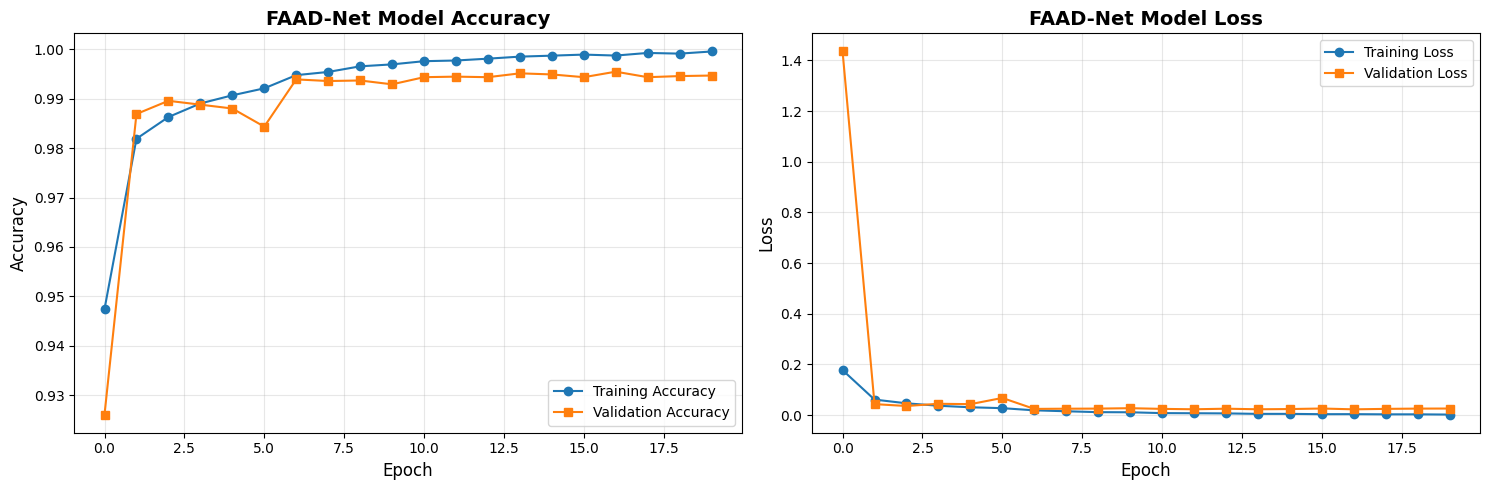

Training/validation plots displayed successfully!


In [9]:
# Plot training history - Accuracy and Loss curves
print("\nGenerating training/validation plots...")

plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('FAAD-Net Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('FAAD-Net Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training/validation plots displayed successfully!")


Generating predictions on validation set...
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step


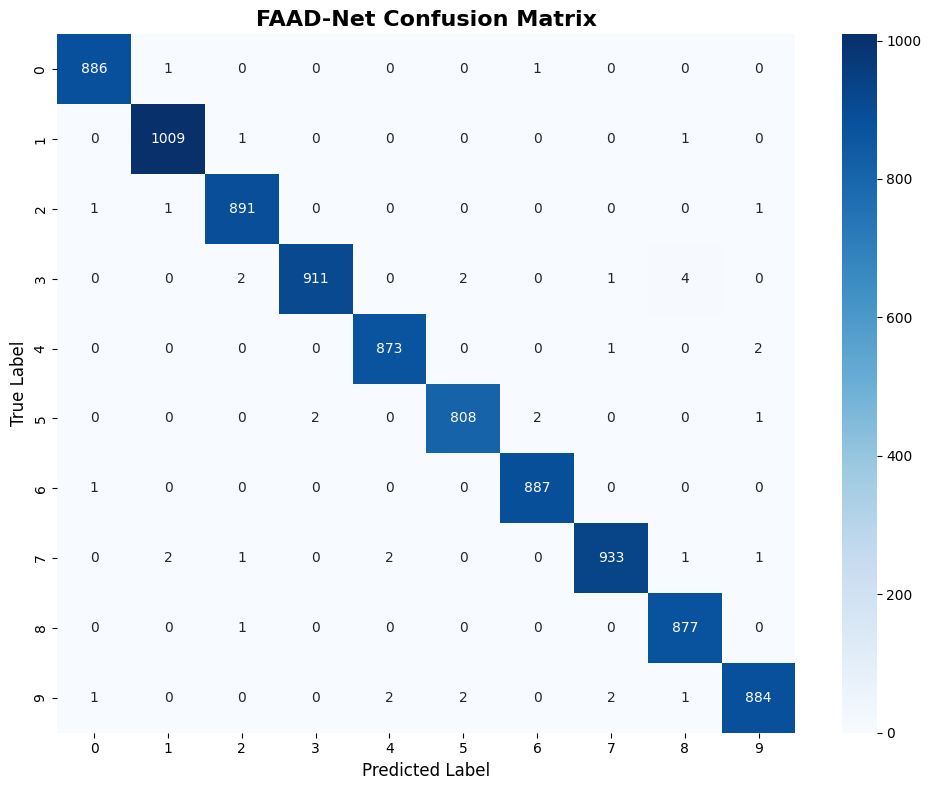


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      1.00      1.00      1011
           2       0.99      1.00      1.00       894
           3       1.00      0.99      0.99       920
           4       1.00      1.00      1.00       876
           5       1.00      0.99      0.99       813
           6       1.00      1.00      1.00       888
           7       1.00      0.99      0.99       940
           8       0.99      1.00      1.00       878
           9       0.99      0.99      0.99       892

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000


Confusion matrix and classification report generated successfully!


In [10]:
# Generate predictions and confusion matrix
print("\nGenerating predictions on validation set...")

# Get predictions
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('FAAD-Net Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred_classes, 
                          target_names=[str(i) for i in range(10)]))

print("\nConfusion matrix and classification report generated successfully!")